#### Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import json
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [2]:
logins = pd.read_json('~/Desktop/logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


It appears there are no null values to worry about in this set.

In [4]:
logins.dtypes

login_time    datetime64[ns]
dtype: object

Resample the login counts by 15 minute intervals.

In [5]:
logins.set_index('login_time', inplace=True)
logins['count'] = 1
logins = logins.resample('15T').sum()
logins.head()

,count
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


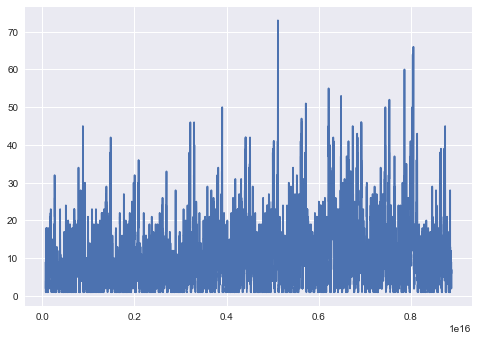

In [6]:
plt.plot(logins)

Plotting all of the dataset shows perhaps some cyclical variation but looking at a smaller time scale may show more.

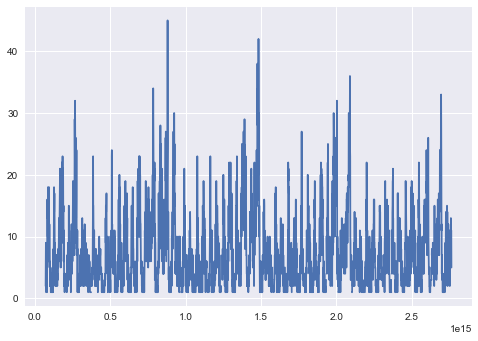

In [7]:
plt.plot(logins['1970-01-01': '1970-02-01'])

Plotting only January 1970's data shows again there is some variation that appears to cycle.

In [8]:
logins2 = pd.read_json('~/Desktop/logins.json')

for logins in logins2:
    logins2['day_of_week'] = logins2['login_time'].map(lambda x: x.weekday())

In [9]:
logins2.head()

,login_time,day_of_week
0,1970-01-01 20:13:18,3
1,1970-01-01 20:16:10,3
2,1970-01-01 20:16:37,3
3,1970-01-01 20:16:36,3
4,1970-01-01 20:26:21,3


In [10]:
def show_trends(df, title, weekends=False):
    new_df = df.set_index('login_time')

    for day in sorted(list(new_df['day_of_week'].unique())):

        temp = new_df[new_df['day_of_week'] == day]
        temp.drop('day_of_week', axis=1, inplace=True)
        temp['count'] = 1
        temp = temp.resample('15T').sum()
        
        if weekends == True:
            if day in [0,1,2,3,4]:
                color = 'blue'
            else:
                color = 'red'
            plt.plot(temp, color=color)
            plt.title(title)
            plt.xticks(rotation=45)
         
        else:
            plt.plot(temp)
            plt.title(title)
            plt.xticks(rotation=45)

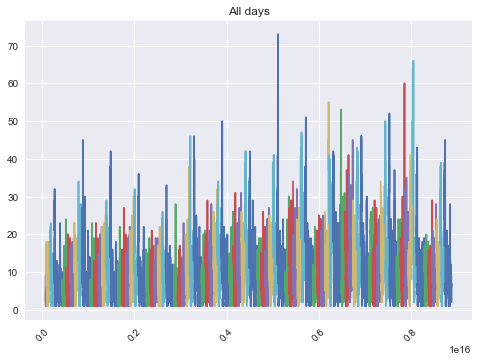

In [11]:
show_trends(logins2, title='All days')

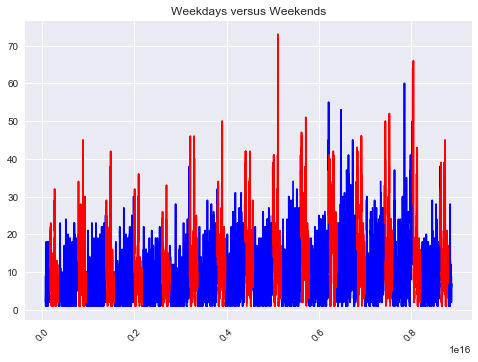

In [12]:
show_trends(logins2, title='Weekdays versus Weekends', weekends=True)

There appears to be a trend towards higher usage on the weekends in this dataset. Usage also may be increasing over time.

#### Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

A metric of success in this instance would be percentage of time drivers spend in each city.  Theoretically right now it's 100% in one city and 0% in the other.  All drivers having a metric of ~50% time in one city or the other would be the ideal.

The experiment could be measured as what percentage of their time each driver spends outside their native city.  The amount a driver spends above 0% outside his native city would be the measure specifically.  This could be tested statistically with a one-tailed Z-test.  

#### Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

In [13]:
file = open('Desktop/ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()

In [14]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [15]:
# Convert dates to date time format
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [16]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


The dataset is evaluated for missing data.

In [17]:
df.isnull().any()

avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
dtype: bool

We can look at the distribution of values for the 3 fields with missing data.

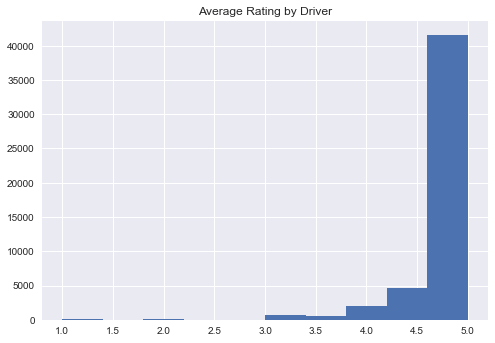

In [18]:
plt.hist(df[np.logical_not(df['avg_rating_by_driver'].isnull())]['avg_rating_by_driver'])
plt.title('Average Rating by Driver')
plt.show()

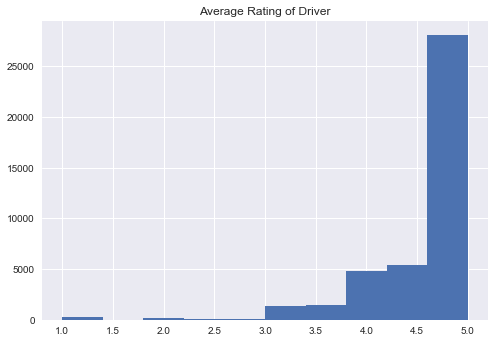

In [19]:
plt.hist(df[np.logical_not(df['avg_rating_of_driver'].isnull())]['avg_rating_of_driver'])
plt.title('Average Rating of Driver')
plt.show()

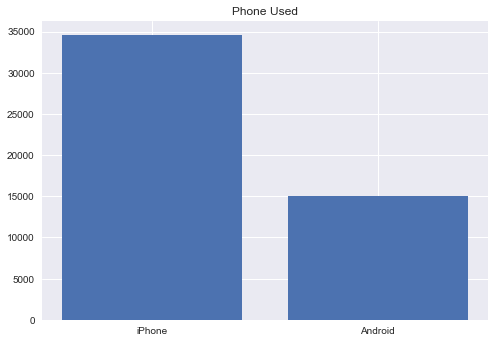

In [20]:
plt.bar([1,2], df[np.logical_not(df['phone'].isnull())]['phone'].value_counts(), align='center')
plt.xticks([1,2], ['iPhone', 'Android'])
plt.title('Phone Used')
plt.show()

Missing values are completed with the mean for the feature (or the higher weighted iPhone over Android).

In [21]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna('iPhone', inplace=True)

In [22]:
df.isnull().any()

avg_dist                  False
avg_rating_by_driver      False
avg_rating_of_driver      False
avg_surge                 False
city                      False
last_trip_date            False
phone                     False
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
dtype: bool

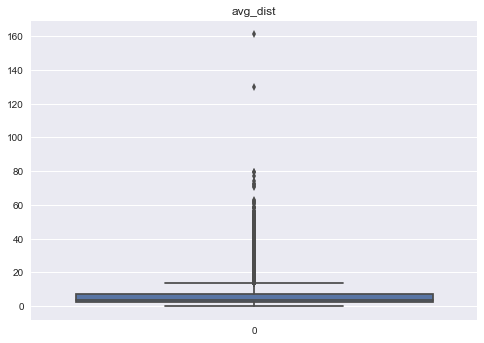

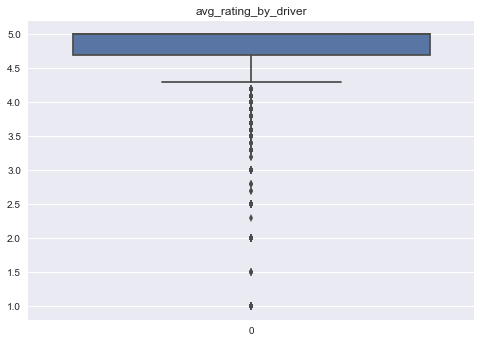

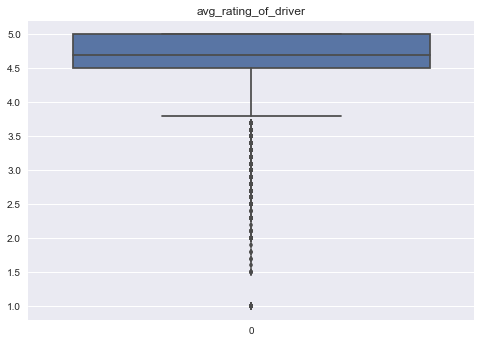

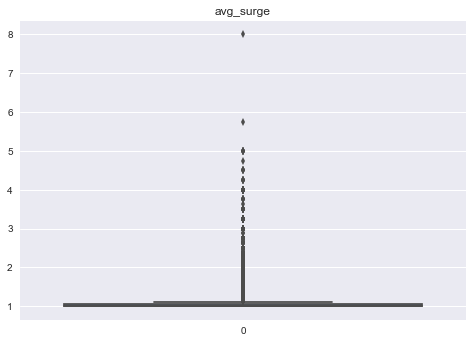

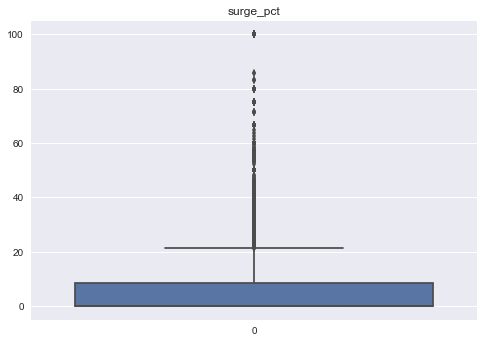

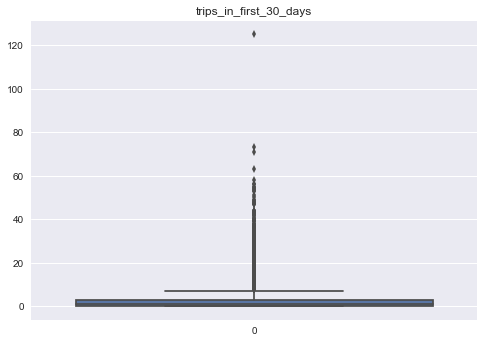

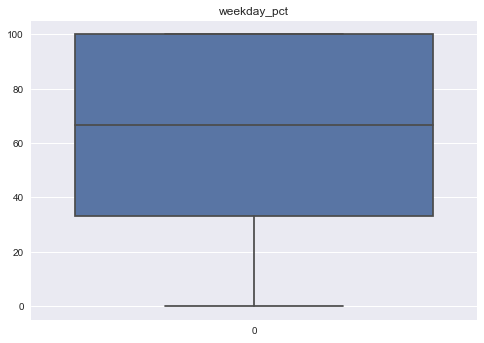

In [23]:
numerical_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                      'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']
for feature in numerical_features:
    sns.boxplot(data=df[feature])
    plt.title(feature)
    plt.show()

Correlations between the features can be evaluated.

In [24]:
df.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
avg_dist,1.000000,0.079793,0.028508,-0.081491,-0.104414,-0.136329,0.032310,0.101652
avg_rating_by_driver,0.079793,1.000000,0.101660,0.010498,0.019964,-0.039097,0.009328,0.020366
avg_rating_of_driver,0.028508,0.101660,1.000000,-0.021653,-0.003290,-0.011060,-0.001916,0.012587
avg_surge,-0.081491,0.010498,-0.021653,1.000000,0.793582,-0.001841,-0.078791,-0.110071
surge_pct,-0.104414,0.019964,-0.003290,0.793582,1.000000,0.005720,-0.106861,-0.144918
trips_in_first_30_days,-0.136329,-0.039097,-0.011060,-0.001841,0.005720,1.000000,0.112210,0.050388
ultimate_black_user,0.032310,0.009328,-0.001916,-0.078791,-0.106861,0.112210,1.000000,0.035998
weekday_pct,0.101652,0.020366,0.012587,-0.110071,-0.144918,0.050388,0.035998,1.000000


Notably, there appears to be a strong correlation between surge_pct and avg_surge, which makes sense.

In [25]:
df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [26]:
len(df[df['last_trip_date'] >= '2014-06-01'])/len(df)*100

37.608000000000004

So 37.6% of users are considered retained.

In [27]:
df['retained'] = np.nan
df.loc[df['last_trip_date'] >= '2014-06-01', 'retained'] = 1
df.loc[df['last_trip_date'] < '2014-06-01', 'retained'] = 0

In [28]:
df.drop('signup_date', axis=1, inplace=True)
df.drop('last_trip_date', axis=1, inplace=True)

In [29]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,15.4,4,True,46.2,1.0
1,8.26,5.0,5.0,1.00,Astapor,Android,0.0,0,False,50.0,0.0
2,0.77,5.0,4.3,1.00,Astapor,iPhone,0.0,3,False,100.0,0.0
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,20.0,9,True,80.0,1.0
4,3.13,4.9,4.4,1.19,Winterfell,Android,11.8,14,False,82.4,0.0


In [30]:
df_encoded = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])
df_encoded.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1.0,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0.0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0.0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1.0,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0.0,0,0,1,1,0,1,0


In [31]:
train, test = train_test_split(df_encoded, test_size=.30, 
                               random_state=42, stratify=df_encoded['retained'])

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print('Train shape: {}\n Test shape: {}'.format(train.shape, test.shape))

Train shape: (35000, 15)
 Test shape: (15000, 15)


In [32]:
from sklearn import cross_validation

target = train['retained']
train = train.drop('retained', axis=1)

clf = DecisionTreeClassifier(max_depth=4)

cv = cross_validation.KFold(len(train), n_folds=10)

cv_count = 1
for traincv, testcv in cv:  
        preds = clf.fit(train.loc[list(traincv),:], 
                        target.loc[list(traincv),]).predict(train.loc[list(testcv),:])
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target.loc[testcv,], preds)
        cv_count += 1

/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [33]:
final_clf = clf.fit(train, target)

test_target = test['retained']
test = test.drop('retained', axis=1)

test_preds = final_clf.predict(test)



print('Test set accuracy: {:.2f}\nConfusion Matrix:\n{}'\
          .format(accuracy_score(test_target, test_preds)*100, 
                  confusion_matrix(test_target, test_preds)))


Test set accuracy: 74.59
Confusion Matrix:
[[7333 2026]
 [1786 3855]]


In [34]:
feature_importance = pd.DataFrame(final_clf.feature_importances_).T
feature_importance.columns = list(train.columns)
feature_importance

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,0.0,0.537245,0.0,0.009227,0.044548,0.0,0.001748,0.0,0.23984,0.0,0.124405,0.004062,0.00196,0.036965


The model has 75% accuracy and indicates that the features of greatest importance are avg_rating_by_driver, city_King's_Landing, and surge_pct.  This model may indicate why users are retained in the most recent month of the dataset but fails to pull on prior information to better parse out the key factors in user retention.

Based on these features of greatest importance, it may be most useful for the company to focus on location (Kings Landing being a factor in retention), charges for surge times, and average rating by driver.